In [2]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
def fun_init(x, theta, u):
    """
    Fonction principale du modèle de fermentation.
    
    Arguments:
        x (list): Variables d'état [X, S, P, O2]
            X: Concentration en levures (g/L)
            S: Concentration en substrat (glucides fermentescibles) (g/L)
            P: Concentration en produit (éthanol) (g/L)
            O2: Concentration en oxygène dissous (mg/L)
        theta (list): Paramètres du modèle
        u (list): Variables manipulées
    
    Returns:
        list: Dérivées des variables d'état
    """
    # Assignation des variables d'état
    [X, S, P, O2] = x

    # Variable manipulée
    [T] = u  # Température

    # Assignation des paramètres
    [mumax, ms, Ks, Yxs, Yps, YO2s, qO2max, KO2ini, Ket, KO2, V] = theta

    # Système d'équations différentielles
    mu = mumax * (S / (S + Ks)) * (Ket / (Ket + P))  # Taux de croissance spécifique
    qp = (mu * Yps / Yxs) * (S / (S + Ksp)) * (KO2ini / (KO2ini + O2))  # Taux de production d'éthanol
    qO2 = qO2max * (O2 / (KO2 + O2))  # Taux de consommation d'oxygène

    # Équations différentielles
    dXdt = mu * X - kd * X  # Évolution de la biomasse
    dSdt = -mu / Yxs * X - qp / Yps * X - ms * X  # Évolution du substrat
    dPdt = qp * X  # Évolution de l'éthanol
    dO2dt = -qO2 * X  # Évolution de l'oxygène dissous

    return [dXdt, dSdt, dPdt, dO2dt]


def dxdt(t, x, theta, t_per):
    """
    Fonction requise par solve_ivp pour résoudre le système d'équations.
    
    Arguments:
        t: Temps
        x: Variables d'état
        theta: Paramètres du modèle
        t_per: Temps de perturbation (non utilisé ici)
    
    Returns:
        list: Dérivées des variables d'état
    """
    u = [0.0]  # Pas de perturbation
    return fun_init(x, theta, u)

In [4]:
# Paramètres cinétiques
mumax = 0.025         # Taux de croissance spécifique maximum (1/h)
kd = mumax/100        # Taux de mortalité spécifique (1/h)
Ks = 5                # Constante d'affinité des levures pour le substrat (g/L)
Ksp = 1               # Constante d'affinité pour la production d'éthanol (g/L)
Yxs = 0.045           # Rendement biomasse/substrat (g levures/g glucides)
Yps = 0.7             # Rendement éthanol/substrat (g éthanol/g glucides)
YO2s = 0.8            # Rendement oxygène/substrat (g O2/g glucides)
qO2max = 2            # Taux de consommation maximum en O2 (mmolO2/gDW/h)
KO2ini = 1            # Constante d'inhibition de l'O2 sur la production d'éthanol (mg/L)
Ket = 25              # Constante d'inhibition de l'éthanol sur la croissance des levures (g/L)
KO2 = 0.1             # Constante d'affinité de l'O2 pour les levures (mg/L)
ms = 0                # Taux de maintenance des levures (gS/gX/h)
V = 20.0              # Volume du fermenteur (L)

# Variable manipulée
T = 23                # Température (°C)

# Regroupement des paramètres
theta = [mumax, ms, Ks, Yxs, Yps, YO2s, qO2max, KO2ini, Ket, KO2, V]

# Conditions initiales
u0 = [0.0]            # Variable manipulée initiale
x0 = [0.4, 150.0, 0.0, 6.0]  # [X0, S0, P0, O2_0]

# Temps de simulation
tspan = [0, 200]      # Durée de simulation (h)

In [5]:
# Résolution du système d'équations différentielles
sim = solve_ivp(
    dxdt,              # Fonction décrivant le système
    tspan,             # Intervalle de temps
    x0,                # Conditions initiales
    method='RK45',     # Méthode de Runge-Kutta d'ordre 4-5
    args=(theta, u0),  # Arguments supplémentaires
    max_step=0.01      # Pas maximum pour assurer une bonne précision
)

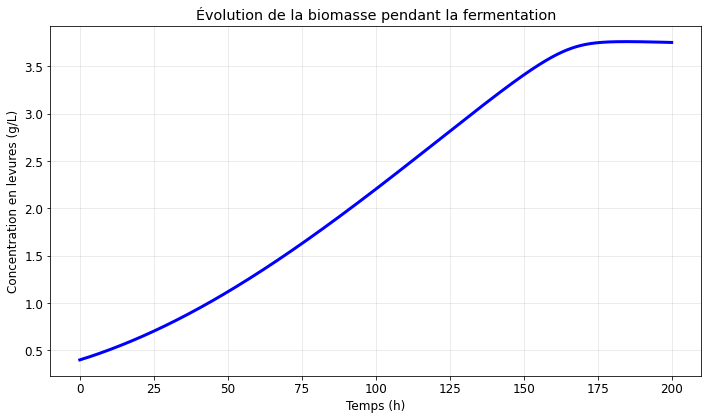

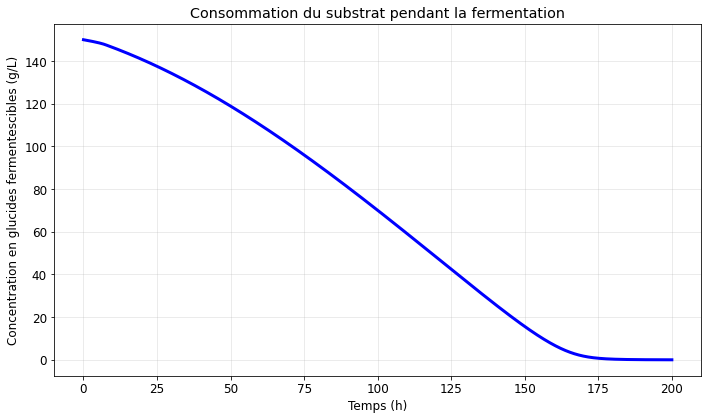

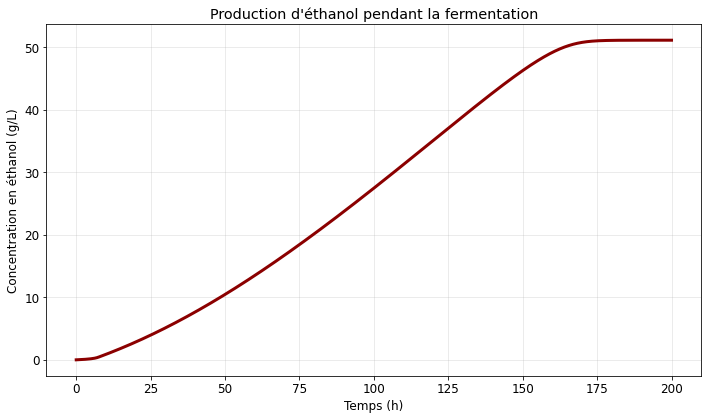

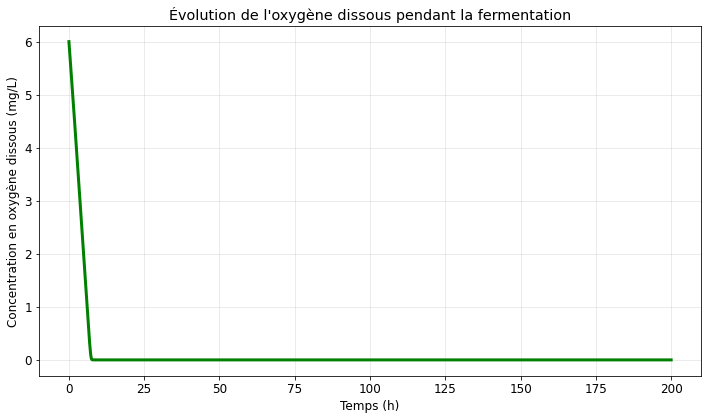

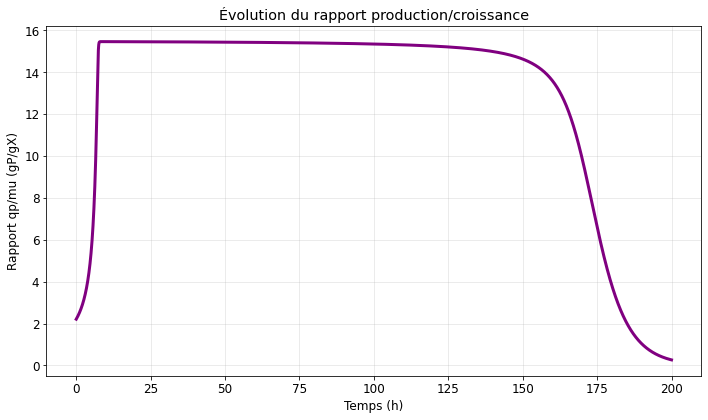

In [6]:
# Configuration du style pour les graphiques
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Création d'une fonction pour générer les graphiques avec un style cohérent
def plot_variable(time, values, ylabel, title, color='blue'):
    """
    Génère un graphique stylisé pour une variable.
    
    Arguments:
        time: Vecteur temps
        values: Valeurs à tracer
        ylabel: Étiquette de l'axe des ordonnées
        title: Titre du graphique
        color: Couleur de la courbe
    """
    plt.figure()
    plt.plot(time, values, color=color, linewidth=3)
    plt.xlabel('Temps (h)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Tracer l'évolution de la biomasse (levures)
plot_variable(
    sim.t, 
    sim.y[0], 
    'Concentration en levures (g/L)', 
    'Évolution de la biomasse pendant la fermentation'
)

# Tracer l'évolution du substrat (glucides fermentescibles)
plot_variable(
    sim.t, 
    sim.y[1], 
    'Concentration en glucides fermentescibles (g/L)', 
    'Consommation du substrat pendant la fermentation'
)

# Tracer l'évolution de l'éthanol
plot_variable(
    sim.t, 
    sim.y[2], 
    'Concentration en éthanol (g/L)', 
    'Production d\'éthanol pendant la fermentation',
    'darkred'
)

# Tracer l'évolution de l'oxygène dissous
plot_variable(
    sim.t, 
    sim.y[3], 
    'Concentration en oxygène dissous (mg/L)', 
    'Évolution de l\'oxygène dissous pendant la fermentation',
    'green'
)

# Calcul des taux spécifiques de croissance et de production
mu = mumax * (sim.y[1] / (sim.y[1] + Ks)) * (Ket / (Ket + sim.y[2]))
qp = (mu * Yps / Yxs) * (sim.y[1] / (sim.y[1] + Ksp)) * (KO2ini / (KO2ini + sim.y[3]))

# Tracer le rapport production/croissance
plot_variable(
    sim.t, 
    qp / mu, 
    'Rapport qp/mu (gP/gX)', 
    'Évolution du rapport production/croissance',
    'purple'
)